In [ ]:
import anndata as ad
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import polars.selectors as cs
import seaborn as sns

In [ ]:
# setting up paths
from pathlib import Path

from dotenv import dotenv_values

paths = dotenv_values()
data_path = Path(paths["DATA_DIR"])

In [ ]:
X = pl.read_parquet(data_path / "processed-data/training_data-counts_uint.parquet").select(
    "sample_index", cs.numeric().cast(pl.UInt16)
)
X

In [ ]:
X.estimated_size("mb")

In [ ]:
X.select(cs.numeric()).max_horizontal().max()

In [ ]:
X.select("SDF4").hvplot.hist(bins=50)

In [ ]:
var = pl.read_csv(data_path / "vcc_data/training_data-col_metadata.csv")
obs = pl.read_csv(data_path / "vcc_data/training_data-row_metadata.csv")

In [ ]:
target_genes = obs.filter(pl.col("target_gene") != "non-targeting").select(
    "sample_index", "target_gene"
)
gene_columns = X.select(cs.numeric()).columns

In [ ]:
# Code for generating ko information data


def generate_ko_data(ko_genes, gene_columns):
    gene_to_idx = {gene: idx for idx, gene in enumerate(gene_columns)}
    ko_gene_data = np.zeros((len(ko_genes), len(gene_columns)), dtype=np.uint8)
    for i, gene in enumerate(ko_genes):
        idx = gene_to_idx.get(gene)
        if idx is not None:
            ko_gene_data[i, idx] = 1
    return ko_gene_data

In [ ]:
ko_gene_data = generate_ko_data(target_genes["target_gene"], gene_columns)
ko_gene_df = pl.DataFrame(ko_gene_data, schema=gene_columns)
ko_gene_df = ko_gene_df.with_columns(target_genes["sample_index"])

In [ ]:
ko_gene_df.shape

In [ ]:
ko_gene_df.estimated_size("mb")

In [ ]:
ko_gene_df[0, "CHMP3"]  # Verificatino

In [ ]:
X.filter(~pl.col("sample_index").is_in(target_genes["sample_index"].implode())).write_parquet(
    data_path / "processed-data/control_exp_data_uint.parquet"
)  # writing control data

In [ ]:
X.sort("sample_index").filter(
    pl.col("sample_index").is_in(target_genes["sample_index"].implode())
).write_parquet(data_path / "processed-data/training_data-counts_uint.parquet")

In [ ]:
ko_gene_df.sort("sample_index").write_parquet(
    data_path / "processed-data/training_data-gene_ko_uint.parquet"
)

In [ ]:
pl.read_parquet(data_path / "processed-data/training_data-gene_ko_uint.parquet")

# Generating Validation

In [ ]:
validation_df = pl.read_csv(data_path / "processed-data/pert_counts_Validation.csv")
validation_df

In [ ]:
validation_df["n_cells"].sum()

In [ ]:
val_genes = [[row[0] for _ in range(row[1])] for row in validation_df.iter_rows()]
val_genes = [i for sublist in val_genes for i in sublist]
len(val_genes)

In [ ]:
val_ko_gene_data = generate_ko_data(val_genes, gene_columns)
val_ko_df = pl.DataFrame(val_ko_gene_data, schema=gene_columns)
val_ko_df

In [ ]:
val_ko_df[0:10, validation_df[0, "target_gene"]]

In [ ]:
val_ko_df.write_parquet(data_path / "processed-data/validation_data-gene_ko.parquet")

In [ ]:
X.select(pl.all_horizontal(cs.numeric().is_infinite()))

In [ ]:
np.sqrt(np.array([-1], dtype=np.float16))

# Preliminary Analysis

In [ ]:
gene = "SAMD11"

print(X[gene].mean())
print(np.log1p(X[gene]).mean())
print(X[gene].sum())
X.filter(pl.col(gene) > 0).shape

In [ ]:
obs

In [ ]:
target_gene_counts = (
    obs["target_gene"].value_counts().sort("count", descending=True)
)  # Gene targeted for CRISPRi
target_gene_counts

In [ ]:
prcp_index = obs.filter(pl.col("target_gene") == "PRCP")[""]
prcp_index

In [ ]:
X.filter(pl.col("sample_index").is_in(prcp_index))

In [ ]:
sns.histplot(x=target_gene_counts["count"][1:], bins=50, kde=True)
plt.title("Perturbed genes - # of samples")

Perturbed genes enrichment

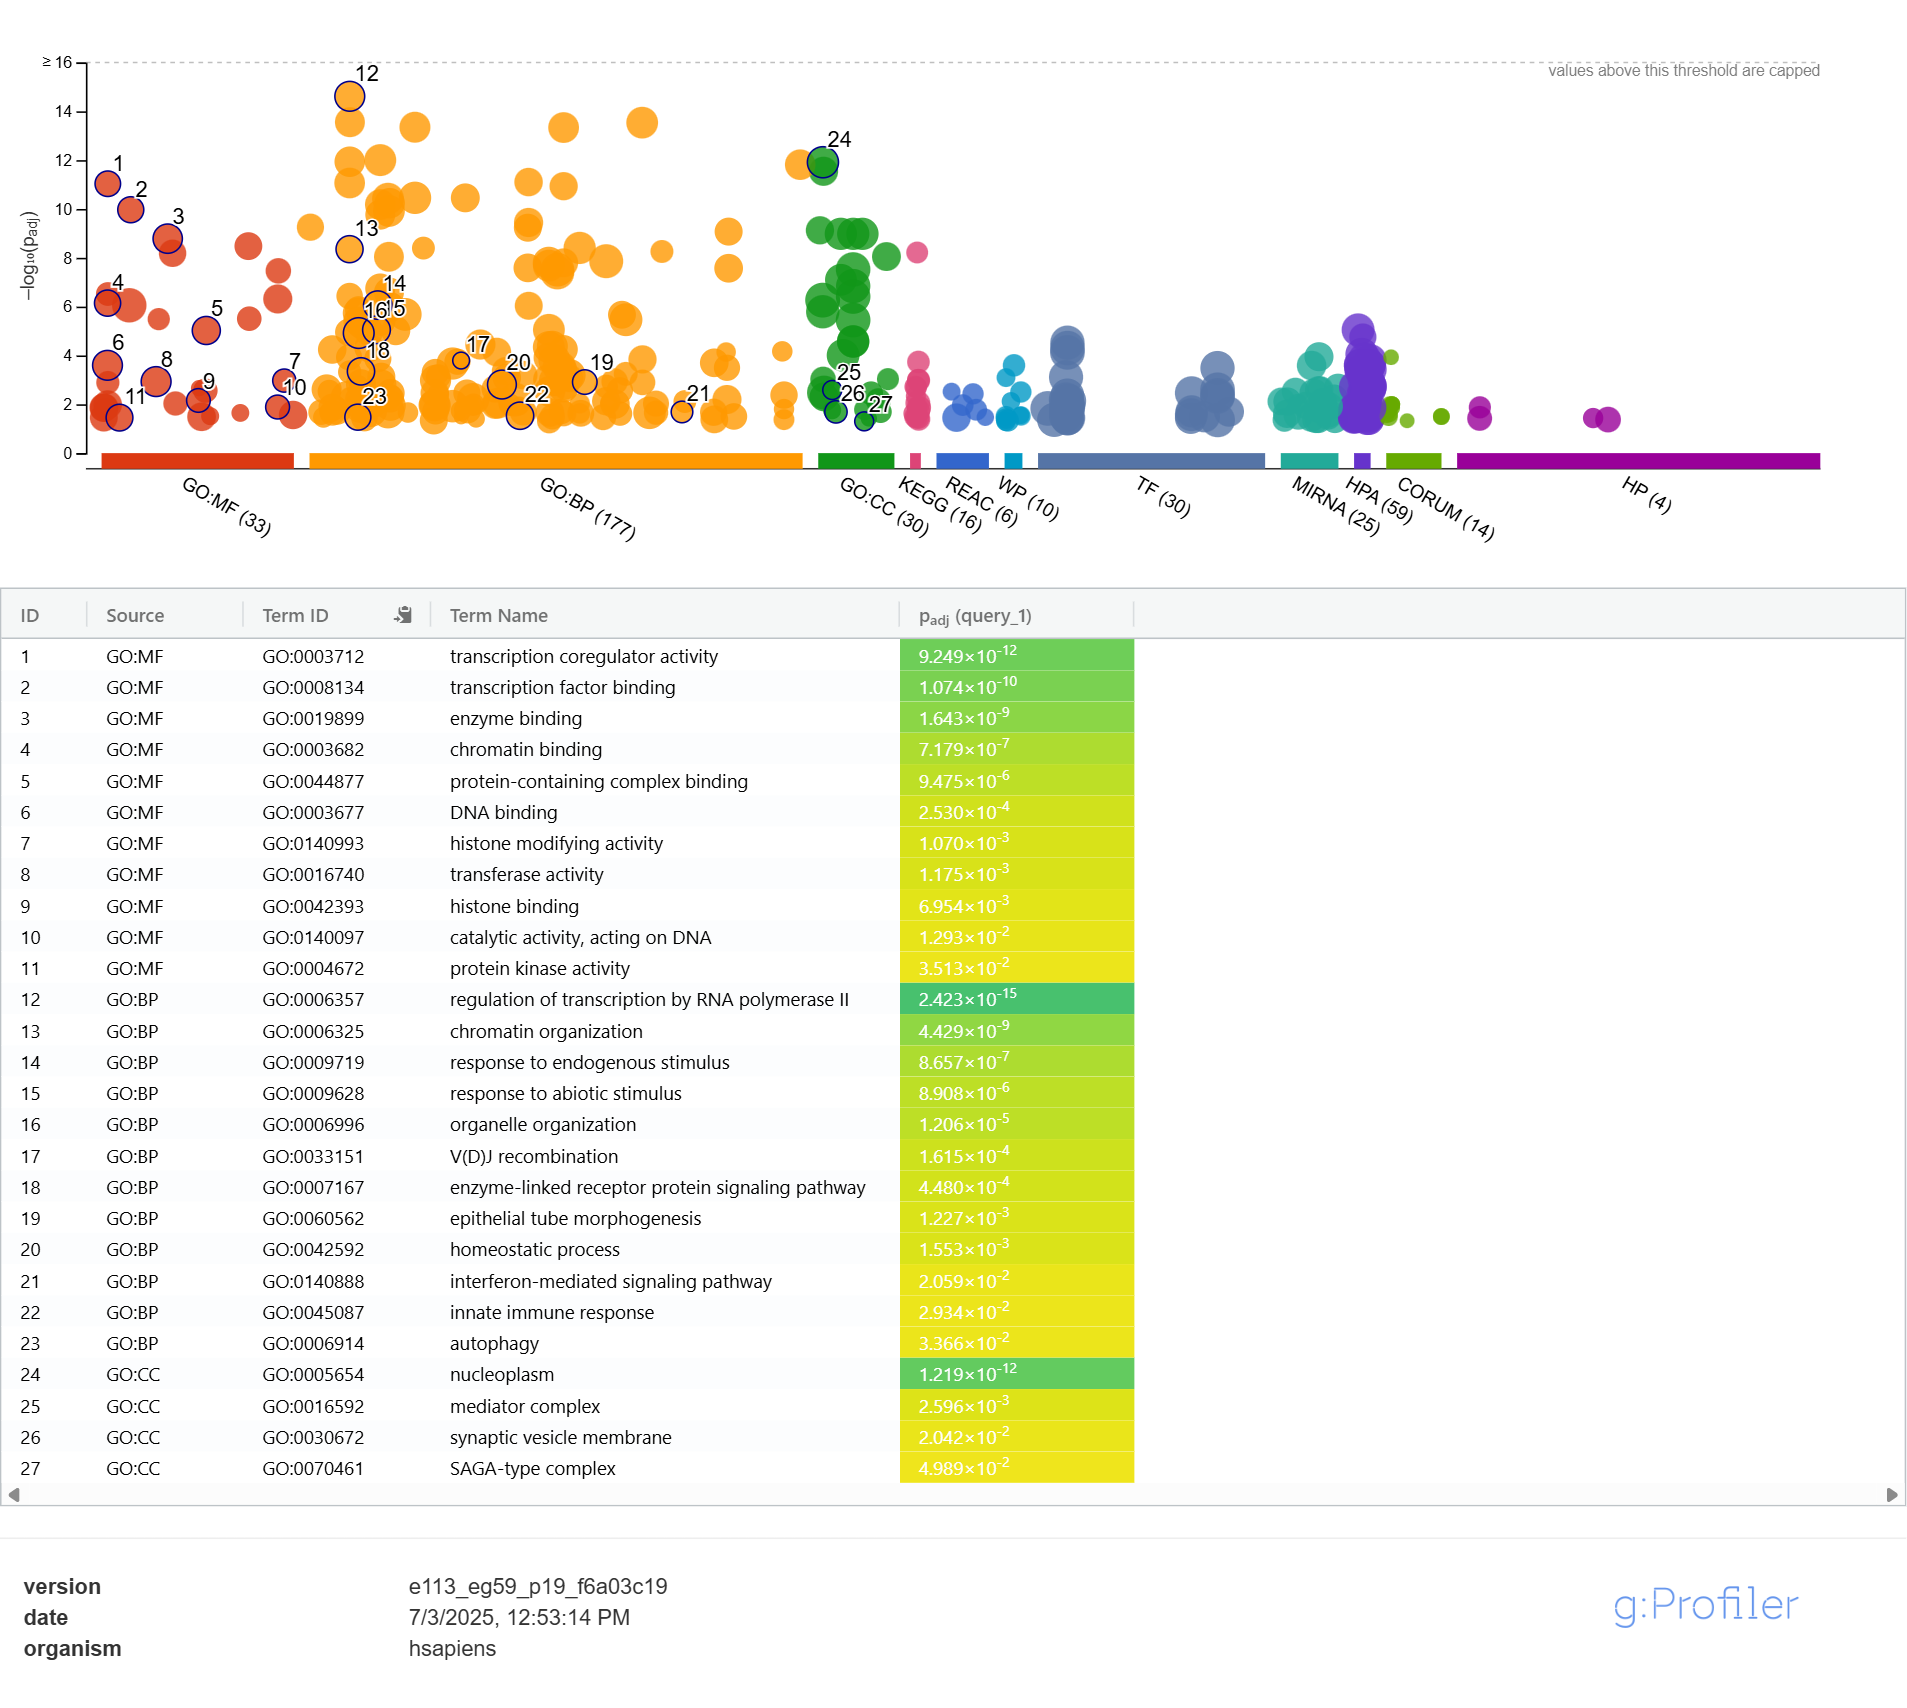

In [ ]:
annot = pl.read_csv("../../vcc-data/vcc_data/gene_names.csv", has_header=False)
test = pl.read_csv("../../vcc-data/vcc_data/pert_counts_Validation.csv")

In [ ]:
annot

In [ ]:
test

In [ ]:
test["n_cells"].sum()

In [ ]:
test["target_gene"]

In [ ]:
X[test["target_gene"].to_list()]

In [ ]:
sns.histplot(x=X["ANXA6"], bins=50)

In [ ]:
X[target_gene_counts["target_gene"].to_list()[1:]]

In [ ]:
np.intersect1d(test["target_gene"].to_list(), target_gene_counts["target_gene"].to_list())

In [ ]:
test

In [ ]:
obs